In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time
from IPython.display import clear_output

from sklearn.decomposition import PCA
import scipy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal


# for IWAE
from scipy.stats import multivariate_normal
from matplotlib import ticker, cm
from matplotlib import gridspec
from matplotlib import collections  as mplc
from scipy.special import logsumexp
# end for IWAE

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 1
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# <span style="color:red"> No! </span>

# dgm_utils
from dgm_utils import train_model, plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

# <center>Deep Generative Models</center>
## <center>Seminar 7. Part 1</center>

<center><img src="pics/mipt_logo.png" width=600 /></center>
<center>06.12.2022</center>


## Plan

1. MADE++
    
    - Discretization of continuous distributions

## MADE++

In [2]:
from seminar7_utils import BananaDistribution, MADE

Recall the **Banana distribution**

In [3]:
N_TRAIN_SAMPLES = 240000
N_TEST_SAMPLES = 60000

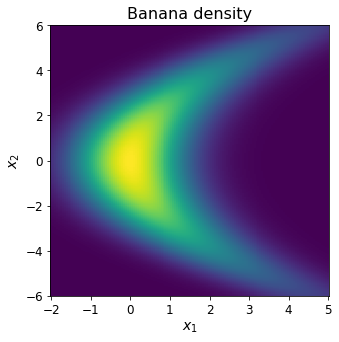

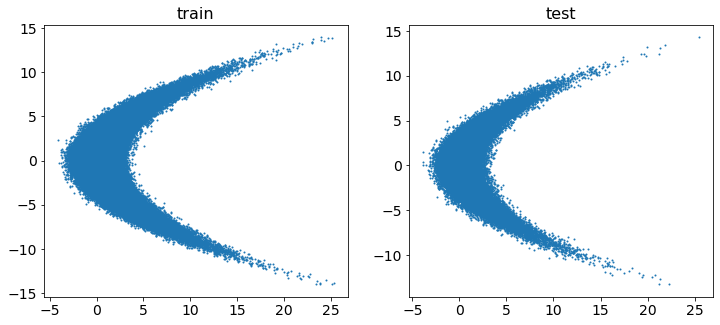

In [4]:
banana_generator = BananaDistribution(device=DEVICE)

################
## Density visualization

dx, dy = 0.05, 0.05
x_lim = (-2, 5)
y_lim = (-6, 6)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]

mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(DEVICE)
densities = banana_generator.prob(mesh_xs).cpu().detach().numpy()
visualize_2d_densities(x, y, densities, title='Banana density', xlabel=r'$x_1$', ylabel=r'$x_2$')

##################
## Dataset

banana_data_train = banana_generator.sample(N_TRAIN_SAMPLES)
banana_data_test = banana_generator.sample(N_TEST_SAMPLES)

visualize_2d_data(
    banana_data_train.cpu().numpy(), 
    banana_data_test.cpu().numpy())

Recall the **Gaussian MADE**

Let $\boldsymbol{x} \sim p(\boldsymbol{x} | \theta) \, , \, \boldsymbol{x} \in \mathbf{R}^d$

**Likelihood factorization**: $p(\boldsymbol{x} | \theta) = \prod\limits_{j = 1}^{d} p\left( x_j | \boldsymbol{x}_{1:j-1}, \theta \right) \approx \prod\limits_{j = 1}^{d} \mathcal{N}\left(x_j \,\middle|\, \mu_j(\boldsymbol{x}_{1:j-1}, \theta), \sigma_j^2(\boldsymbol{x}_{1:j-1}, \theta)\right)$

**Sampling procedure**:

* Sample $\hat{x}_1 \sim \mathcal{N}\left(\mu_1(\theta), \sigma_1^2(\theta)\right)$

* Sample $\hat{x}_2 \sim \mathcal{N}\left(\mu_2(\hat{x}_1, \theta), \sigma_2^2(\hat{x}_1, \theta)\right)$

* ...

* Sample $\hat{x}_d \sim \mathcal{N}\left( \mu_d(\hat{\boldsymbol{x}}_{\pi_{1:d-1}}, \theta), \sigma_d^2(\hat{\boldsymbol{x}}_{\pi_{1:d-1}}, \theta)\right)$

In [5]:
class GaussianMADE(MADE):

    def __init__(self, dim, hidden_sizes):
        out_bins = 2 # number of output features per each dimension (\mu, \sigma)
        super().__init__(dim, hidden_sizes, out_bins)

    def forward(self, x):
        """
        :Parameters:
        x: torch.Size([bs, D]) : input sample
        :Output:
        out : torch.Size([bs, D, 2]) : output 
        """
        logits = super().forward(x) # torch.tensor ([B, D * 2])
        logits = logits.view(-1, self.dim, 2)
        return logits

    def loss(self, x):
        nll = - self.log_prob(x)
        total_loss = nll.mean()
        return {'total_loss': total_loss}

    def log_prob(self, x):
        logits = self(x)
        mus = logits[..., 0]
        log_sigmas = logits[..., 1]
        sigmas = torch.exp(log_sigmas)
        distr = TD.Normal(mus, sigmas)
        return distr.log_prob(x).sum(-1)

    def prob(self, x):
        return torch.exp(self.log_prob(x))

Recall the learning of **Banana distribution** with **Gaussian MADE**

In [6]:
HIDDEN_SIZES = [20, 20, 20]

model = GaussianMADE(2, HIDDEN_SIZES).to(DEVICE)
# model.visualize_masks()

BATCH_SIZE = 256
EPOCHS = 2
LR = 0.01

train_loader = data.DataLoader(banana_data_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(banana_data_train, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_tqdm=True)

  0%|          | 0/2 [00:00<?, ?it/s]

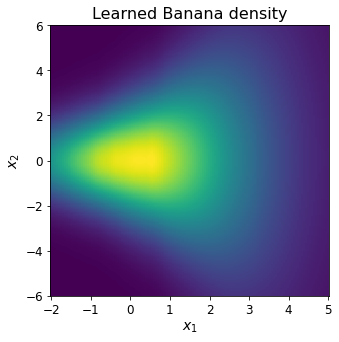

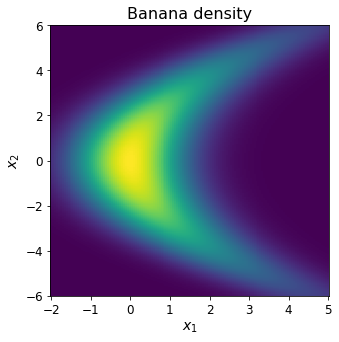

In [7]:
################
## Density visualization
model.eval()

dx, dy = 0.05, 0.05
x_lim = (-2, 5)
y_lim = (-6, 6)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]

mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(DEVICE)

#### Learned distribution visualization
with torch.no_grad():
    learned_densities = model.prob(mesh_xs).cpu().detach().numpy()
visualize_2d_densities(
    x, y, 
    learned_densities, 
    title='Learned Banana density', xlabel=r'$x_1$', ylabel=r'$x_2$')

#### Original distribution visualization
original_densities = banana_generator.prob(mesh_xs).cpu().detach().numpy()
visualize_2d_densities(
    x, y, 
    original_densities, title='Banana density', xlabel=r'$x_1$', ylabel=r'$x_2$')

### **MADE++** (for **continuous** distribution)

Let $\boldsymbol{x} \sim p(\boldsymbol{x} | \theta) \, , \, \boldsymbol{x} \in \mathbf{R}^d$

**Likelihood factorization**: $p(\boldsymbol{x} | \theta) = \prod\limits_{j = 1}^{d} p\left( x_j | \boldsymbol{x}_{1:j-1}, \theta \right) \approx \prod\limits_{j = 1}^{d} p_{\text{MoL}}\left(x_j \,\middle|\, \pi_j^{(1:K)}(\boldsymbol{x}_{1:j-1}, \theta) \, , \, \mu_j^{(1:K)}(\boldsymbol{x}_{1:j-1}, \theta)\, ,\, s_j^{(1:K)}(\boldsymbol{x}_{1:j-1}, \theta)\right)$

In the equation above $p_{\text{MoL}}$ is mixture of logistic distributions:

$$p_{\text{MoL}}\left(x \,\middle|\, \pi^{(1:K)} \, , \, \mu^{(1:K)}\, ,\, s^{(1:K)}\right) = \sum\limits_{k = 1}^{K} \pi^{(k)} \text{Logistic}(x | \mu^{(k)}, s^{(k)})$$

**Logistic distribution pdfs**

<center><img src="pics/Logisticpdfunction.png" width=600 /></center>

**Logistic distribution cdfs** (scaled and shifted sigmoids)

<center><img src="pics/Logistic_cdf.png" width=600 /></center>

Why Logistic distribution?

[PixelCNN++](https://arxiv.org/pdf/1701.05517.pdf) utilizes logistic distributions.

In [8]:
def Logistic(loc, scale):
    return TD.TransformedDistribution(
        TD.Uniform(torch.zeros_like(loc), torch.ones_like(loc)),
        [TD.SigmoidTransform().inv, TD.AffineTransform(loc, scale)]
    )

def recover_logistic_mixture(
    logit, # (bs, D, 3 * K)
    logit2pi = lambda x: torch.softmax(x, dim=-1), # components of the categorical distribution
    logit2mu = lambda x: x,
    logit2scale = lambda x: torch.exp(x)): # scales are positive
    '''
    logit : tensor (bs, D, 3 * K), K is the number of logistic distributions in the mixture
    '''
    assert logit.size(-1) == (logit.size(-1) // 3) * 3

    # prepare distribution parameters from logits
    K = logit.size(-1) // 3 # number of components in the mixture
    pis = logit2pi(logit[..., :K]) # (bs, D, K)
    mus = logit2mu(logit[..., K:2*K]) # (bs, D, K)
    scales = logit2scale(logit[..., 2*K:]) # (bs, D, K)
    
    distr = TD.MixtureSameFamily(
        TD.Categorical(probs=pis),
        Logistic(loc=mus, scale=scales))
    return distr

LogisticMixtureMADE models

In [9]:
class LogisticMixtureMADE(MADE):

    def __init__(self, dim, K, hidden_sizes):
        '''
        K : number of components of the mixture
        '''
        out_bins = 3 * K # number of output features per each dimension (\pi, \mu, \scale)
        super().__init__(dim, hidden_sizes, out_bins)

    def forward(self, x):
        """
        :Parameters:
        x: torch.Size([bs, D]) : input sample
        :Output:
        out : torch.Size([bs, D, 3 * K]) : output 
        """
        logits = super().forward(x) # torch.tensor ([B, D * 3 * K])
        logits = logits.view(-1, self.dim, self.out_bins) # ([B, D, 3*K])
        return logits
    
    def log_prob(self, x):
        raise NotImplementedError()

    def prob(self, x):
        return torch.exp(self.log_prob(x))

class LogisticMixtureContinuousMADE(LogisticMixtureMADE):

    def loss(self, x):
        nll = - self.log_prob(x)
        total_loss = nll.mean()
        return {'total_loss': total_loss}

    def log_prob(self, x):
        logits = self(x) # (b, D, 3 * K)
        distr = recover_logistic_mixture(logits)
        return distr.log_prob(x).sum(-1)

In [10]:
HIDDEN_SIZES = [40, 40, 40]
K=5

model = LogisticMixtureContinuousMADE(2, K, HIDDEN_SIZES).to(DEVICE)
# model.visualize_masks()

BATCH_SIZE = 256
EPOCHS = 4
LR = 0.01

train_loader = data.DataLoader(banana_data_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(banana_data_train, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_tqdm=True)

  0%|          | 0/4 [00:00<?, ?it/s]

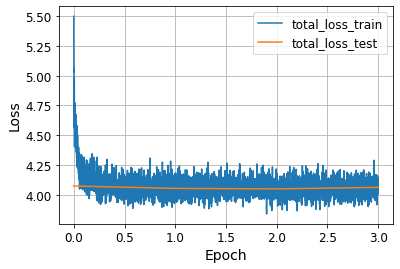

In [11]:
plot_training_curves(train_losses, test_losses)

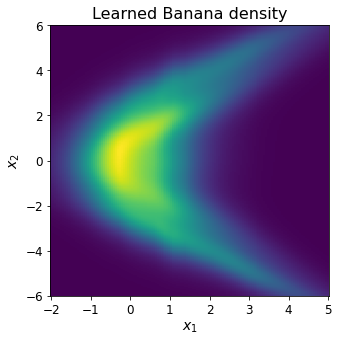

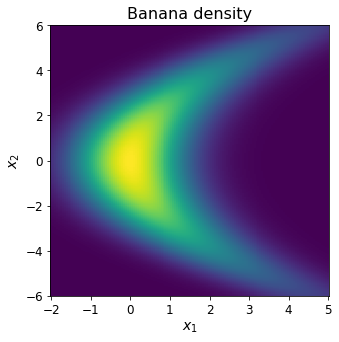

In [12]:
################
## Density visualization
model.eval()

dx, dy = 0.05, 0.05
x_lim = (-2, 5)
y_lim = (-6, 6)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]

mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(DEVICE)

#### Learned distribution visualization
with torch.no_grad():
    learned_densities = model.prob(mesh_xs).cpu().detach().numpy()
visualize_2d_densities(
    x, y, 
    learned_densities, 
    title='Learned Banana density', xlabel=r'$x_1$', ylabel=r'$x_2$')

#### Original distribution visualization
original_densities = banana_generator.prob(mesh_xs).cpu().detach().numpy()
visualize_2d_densities(
    x, y, 
    original_densities, title='Banana density', xlabel=r'$x_1$', ylabel=r'$x_2$')

### **MADE++** (for **discrete** distribution) (discretization of continuous distributions)

Inspired by [PixelCNN++](https://arxiv.org/pdf/1701.05517.pdf)

**Question** Let $x \sim \pi(x)$, 
$$x \in \left\{\frac{p}{b}, \frac{p + 1}{b}, \dots , \frac{q - 1}{b}, \frac{q}{b}\right\} \\ \text{where }b > 0\,,\,p < q \, , \, q - p + 1 = K \in \mathbb{N}_{+}$$

I.e. $\pi(x)$ is $\text{Categorical}(\pi^*_1, \dots \pi^*_{K})$

Let $p(x | \theta)$ is a **continious** parametric distribution we model based on samples $X \sim \pi(x)$.

How to derive the parameters $\hat{\pi}^*_1, \hat{\pi}^*_2, \dots \hat{\pi}^*_K$ based on $p(x | \theta)$? (for example, we need these parameters for MLE estimator)

**Answer** 

Let $\hat{\pi}_{\theta}$ is the estimator of $\pi(x)$ modelled via $p(x|\theta)$. Then:

$$\hat{\pi}_{\theta}\left(\left\{x = \frac{p + k}{b}\right\}\right) = \hat{\pi}^*_{k + 1} = \begin{cases}F_{p(\cdot|\theta)}\left(\frac{p + k}{b} + \frac{0.5}{b}\right) - F_{p(\cdot|\theta)}\left(\frac{p + k}{b} - \frac{0.5}{b}\right)\, , \, &k > 0, k < K - 1 \\ 1 - F_{p(\cdot|\theta)}\left(\frac{q}{b} - \frac{0.5}{b}\right)\, , &k = K - 1 \\ F_{p(\cdot|\theta)}\left(\frac{p}{b} + \frac{0.5}{b}\right)\, , \, &k = 0
\end{cases}
$$

In [13]:
from seminar7_utils import generate_2d_image_data, plot_2d_image_data

Recall the Einstein image distribution from the first seminars

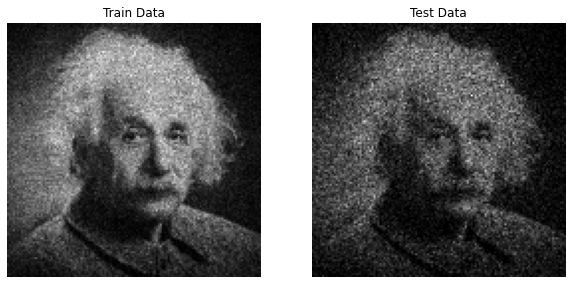

In [14]:
COUNT = 500000
BINS = 128

image, ein_train_data, ein_test_data = generate_2d_image_data(COUNT, bins=BINS)
plot_2d_image_data(ein_train_data, ein_test_data, BINS)

In [15]:
def scale_2d_image_data(data, bins=BINS):
    '''
    :Parameters:
    data: ndarray (N, 2) : pixel coordinates in {0, 1, \dots BINS-1}
    '''
    loc = float(bins - 1)/2.
    scale = float(bins)/2.
    res = (data.astype(np.float32) - loc)/scale
    assert res.max() <= 1.
    assert res.min() >= -1
    return res

def undo_scale_2d_image_data(data, bins=BINS):
    '''
    :Parameters:
    data: ndarray (N, 2) : scaled pixel coordinates in [-1, 1]
    '''
    loc = float(bins - 1)/2.
    scale = float(bins)/2.
    return data.astype(np.float32) * scale + loc

In [16]:
np.allclose(undo_scale_2d_image_data(scale_2d_image_data(ein_train_data, bins=BINS), bins=BINS), ein_train_data)

True

Scale the data to be in range $(-1, 1)$

In [17]:
ein_train_data = torch.tensor(scale_2d_image_data(ein_train_data, bins=BINS)).to(DEVICE)
ein_test_data = torch.tensor(scale_2d_image_data(ein_test_data, bins=BINS)).to(DEVICE)

In [18]:
def logistic_log_prob_discrete(logit, X, bins=BINS):
    '''
    logit: tensor (bs, D, 3 * K)
    X: tensor (bs, D), pixel coordinates in the range [-1, 1]
    '''
    distr = recover_logistic_mixture(
        logit, 
        logit2mu=lambda x: torch.tanh(x) # limits mus to be in the range (-1, 1)
    )

    # estimate the P(X | pis, mus, scales) = 
    # = F(X + 1/128 | pics, mus, scales) - F(X - 1/128 | pics, mus, scalse) if X < 1 - 1/128 and X > -1 + 1/128
    # = 1 - F(X - 1/128 | pics, mus, scales) if X >= 1 - 1/128
    # = F(X + 1/128 | pics, mus, scales), if X <= -1 + 1/128

    scale = float(bins)/2.
    F_X_plus = distr.cdf(X + 0.5/scale)
    F_X_minus = distr.cdf(X - 0.5/scale)
    F_X_plus[X >= 1. - 0.75/scale] = 1.
    F_X_minus[X <= -1. + 0.75/scale] = 0.
    prob = F_X_plus - F_X_minus
    return torch.log(prob).sum(-1)

In [19]:
class LogisticMixtureDiscreteMADE(LogisticMixtureMADE):

    def loss(self, x):
        nll = - self.log_prob(x)
        total_loss = nll.mean()
        return {'total_loss': total_loss}

    def log_prob(self, x):
        logits = self(x) # (b, D, 3 * K)
        return logistic_log_prob_discrete(logits, x, bins=BINS)

In [20]:
HIDDEN_SIZES = [128, 128, 128]
K=20 # logit : (bs, 2 * 20 * 3)

model = LogisticMixtureDiscreteMADE(2, K, HIDDEN_SIZES).to(DEVICE)
# model.visualize_masks()

BATCH_SIZE = 1024
EPOCHS = 15
LR = 0.003

train_loader = data.DataLoader(ein_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(ein_test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_tqdm=True)

  0%|          | 0/15 [00:00<?, ?it/s]

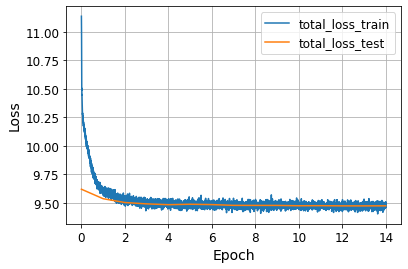

In [21]:
plot_training_curves(train_losses, test_losses)

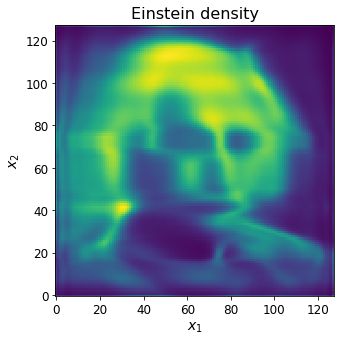

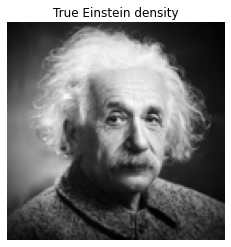

In [22]:
################
## Density visualization

dx, dy = 1., 1.
x_lim = (0, BINS-1)
y_lim = (0, BINS-1)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]

mesh_xs = torch.FloatTensor(
    scale_2d_image_data(np.stack([y[::-1], x[::-1]], axis=2).reshape(-1, 2))).to(DEVICE)
densities = model.prob(mesh_xs).cpu().detach().numpy()
visualize_2d_densities(
    x, y, 
    densities, title='Einstein density', xlabel=r'$x_1$', ylabel=r'$x_2$')

plt.imshow(image, cmap='gray')
plt.title('True Einstein density')
plt.axis('off')
plt.show()

### PixelCNN++ comments

<center><img src="pics/pixelcnn_border_pixels.png" width=600 /></center>

* It is natural to model the extreme ($0$ and $255$) pixel values with $F_{p(\cdot|\theta)}(0 + 0.5)$ and $1 - F_{p(\cdot|\theta)}( 255 - 0.5)$ accordingly